## See if the MCTS runs found all the highest-reward structures

In [207]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='notebook',
    # font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [3]:
print(np.__version__)
print(pd.__version__)

1.22.3
1.4.2


In [4]:
import nfp
print(nfp.__version__)

2022-07-05 11:04:00.659457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-07-05 11:04:00.659494: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.3.12


In [5]:
os.chdir('../')

In [171]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal.crystal_state import CrystalState
from rlmolecule.crystal.crystal_reward import StructureRewardBattInterface

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [7]:
cols = ['decor_id',
        'reward',
        'predicted_energy',
        'decomp_energy',
        'cond_ion_frac',
        'reduction',
        'oxidation',
        'stability_window',
        ]

In [8]:
# rewards_file = "outputs/20220620_rewards/20220621_decors_cond_ion_cutoff_rewards.csv.gz"
rewards_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/2022-06-22-all_decor_rewards.csv.gz"
df = pd.read_csv(rewards_file,
                 names=cols)
print(len(df))
df.head(2)

7698996


,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,Li1Ti2Ge1Cl1N4|_1_1_1_2_4|orthorhombic|icsd_41...,0.015,0.299,7.325,0.111,NaN,NaN,NaN
1,Li1La1Sb1I3O3|_1_1_1_3_3|monoclinic|icsd_17166...,0.036,-0.391,4.621,0.111,NaN,NaN,NaN


In [9]:
print(len(df[df.reward > .6]))
print(len(df[df.reward > 1]))

34296
7


Text(0.5, 1.0, 'Structures not found by MCTS (7698996)')

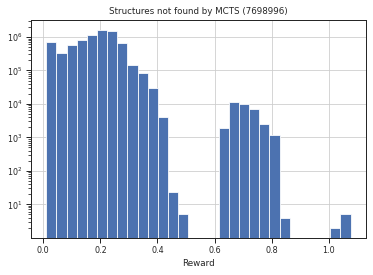

In [11]:
df.reward.hist(bins=30)
plt.yscale("log")
plt.xlabel("Reward")
plt.title(f"Structures not found by MCTS ({len(df)})")

In [14]:
df['comp'] = df.decor_id.apply(lambda x: x.split("|")[0])

In [15]:
df[df.reward >= 1].comp.unique()

array(['K3Sc1Br4I2', 'Li3Sc1Br4I2', 'K3Sc1Br2I4'], dtype=object)

In [14]:
# also load the best decorations
best_decorations_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/batt-icsd-vol-3runs/best_decorations.csv"
df_mcts_best = pd.read_csv(best_decorations_file)
df_mcts_best.head()

,run_id,id,decor_id,comp,reward,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,decomp_energy_s_w,cond_ion_frac_s_w,reduction_s_w,oxidation_s_w,stability_window_s_w,run_id.1
0,20220617-batt-icsd-vol-r90-2,Li3Sc1Br6_icsd_401335_1,Li3Sc1Br6|_1_3_6|trigonal|icsd_401335|1,Li3Sc1Br6,1.118399,-0.7607,0.3000,-0.9753,-5.0000,4.0247,0.640078,0.083333,0.044719,0.055556,0.044719,20220617-batt-icsd-vol-r90-2
1,20220617-batt-icsd-vol-r90-2,Na3Sc1I6_icsd_401335_1,Na3Sc1I6|_1_3_6|trigonal|icsd_401335|1,Na3Sc1I6,1.093755,-0.5759,0.3000,-0.9160,-4.7555,3.8394,0.619544,0.083333,0.045378,0.052839,0.042660,20220617-batt-icsd-vol-r90-2
2,20220617-batt-icsd-vol-r90-2,K5Y1Br8_icsd_262807_1,K5Y1Br8|_1_5_8|triclinic|icsd_262807|1,K5Y1Br8,1.093518,-0.5104,0.3571,-1.5579,-5.0000,3.4421,0.612267,0.099194,0.038246,0.055556,0.038246,20220617-batt-icsd-vol-r90-2
3,20220617-batt-icsd-vol-r90-2,K5Sc1Br8_icsd_262807_1,K5Sc1Br8|_1_5_8|triclinic|icsd_262807|1,K5Sc1Br8,1.088508,-0.4871,0.3571,-1.6667,-5.0000,3.3333,0.609678,0.099194,0.037037,0.055556,0.037037,20220617-batt-icsd-vol-r90-2
4,20220617-batt-icsd-vol-r90-2,Na3Al1Br6_icsd_401335_1,Na3Al1Br6|_1_3_6|trigonal|icsd_401335|1,Na3Al1Br6,1.070164,-0.5054,0.3000,-1.8697,-5.0000,3.1303,0.611711,0.083333,0.034781,0.055556,0.034781,20220617-batt-icsd-vol-r90-2


<AxesSubplot:>

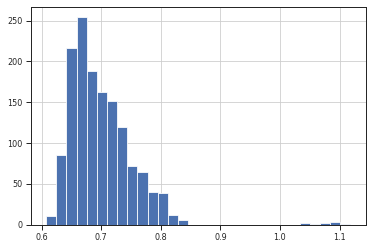

In [15]:
df_mcts_best.reward.hist(bins=30)

In [10]:
# see if the search found structures for those compositions
df_mcts = pd.read_csv("/projects/rlmolecule/jlaw/crystal_outputs/2022-06-20/batt-icsd-vol-3runs/all_decorations.csv.gz",
                      index_col=0)
df_mcts.head()

,run_id,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,oxidation,reduction,stability_window
769706,20220617-batt-icsd-vol-r90-2,Li3Y1Br6|_1_3_6|trigonal|icsd_053533|1,1.135173,-3.798492,-0.8512,0.3000,-5.0,-0.6734,4.3266
7954,20220617-batt-icsd-vol-r90-2,Li4Y1Br7|_1_4_7|cubic|icsd_001322|1,1.132112,-3.735198,-0.7266,0.3333,-5.0,-0.6045,4.3955
1065663,20220617-batt-icsd-vol-r90-2,Li3Y1Br6|_1_3_6|monoclinic|icsd_089617|1,1.132104,-3.781916,-0.8347,0.3000,-5.0,-0.7286,4.2714
913341,20220617-batt-icsd-vol-r90-2,K3Y1Br6|_1_3_6|trigonal|icsd_062035|1,1.131983,-3.724380,-0.8855,0.3000,-5.0,-0.9881,4.0119
43119,20220617-batt-icsd-vol-r90-2,K3Y1Br6|_1_3_6|trigonal|icsd_183024|1,1.131288,-3.720631,-0.8817,0.3000,-5.0,-1.0006,3.9994


In [11]:
df_mcts['comp'] = df_mcts.decor_id.apply(lambda x: x.split('|')[0])

In [16]:
comps_missed = set(df[df.reward > .6].comp) - set(df_mcts.comp)
len(comps_missed)

576

In [17]:
df_mcts.comp.nunique()

145145

In [18]:
len(df_mcts)

6703705

0


<AxesSubplot:>

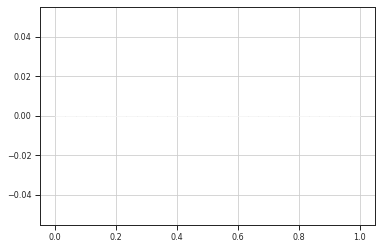

In [24]:
df_mcts_comps_missed = df_mcts[df_mcts.comp.isin(comps_missed)]
print(df_mcts_comps_missed.comp.nunique())
df_mcts_comps_missed.decomp_energy.hist(bins=30)

In [25]:
df_mcts_comps_missed.head(2)

,Unnamed: 0,run_id,decor_id,predicted_energy,decomp_energy,cond_ion_frac,oxidation,reduction,stability_window,comp


In [19]:
df.head(2)

,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,comp
0,Li1Ti2Ge1Cl1N4|_1_1_1_2_4|orthorhombic|icsd_41...,0.015,0.299,7.325,0.111,NaN,NaN,NaN,Li1Ti2Ge1Cl1N4
1,Li1La1Sb1I3O3|_1_1_1_3_3|monoclinic|icsd_17166...,0.036,-0.391,4.621,0.111,NaN,NaN,NaN,Li1La1Sb1I3O3


In [21]:
df = df.drop_duplicates(subset=['decor_id'])

In [22]:
len(df_mcts)

6703705

In [23]:
df_mcts.decor_id.nunique()

6703705

In [24]:
df_mcts.head(2)

,run_id,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,oxidation,reduction,stability_window,comp
769706,20220617-batt-icsd-vol-r90-2,Li3Y1Br6|_1_3_6|trigonal|icsd_053533|1,1.135173,-3.798492,-0.8512,0.3000,-5.0,-0.6734,4.3266,Li3Y1Br6
7954,20220617-batt-icsd-vol-r90-2,Li4Y1Br7|_1_4_7|cubic|icsd_001322|1,1.132112,-3.735198,-0.7266,0.3333,-5.0,-0.6045,4.3955,Li4Y1Br7


In [25]:
df_merged = pd.concat([df, df_mcts])

In [39]:
df_merged.head(2)

,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,comp,Unnamed: 0,run_id
0,Li1Ti2Ge1Cl1N4|_1_1_1_2_4|orthorhombic|icsd_41...,0.015,0.299,7.325,0.111,NaN,NaN,NaN,Li1Ti2Ge1Cl1N4,NaN,NaN
1,Li1La1Sb1I3O3|_1_1_1_3_3|monoclinic|icsd_17166...,0.036,-0.391,4.621,0.111,NaN,NaN,NaN,Li1La1Sb1I3O3,NaN,NaN


In [40]:
df_merged.decor_id.nunique()

14348831

In [26]:
df_merged = df_merged.drop_duplicates(subset='decor_id')

In [27]:
len(df_merged)

14348831

In [35]:
def extract_id(decorated_str):
    decor_split = decorated_str.split('|')
    try:
        out_str = '_'.join([decor_split[0], decor_split[3].replace('POSCAR_',''), decor_split[4]])
    except:
        return None
    return out_str

In [30]:
df.head(2)

,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,comp
0,Li1Ti2Ge1Cl1N4|_1_1_1_2_4|orthorhombic|icsd_41...,0.015,0.299,7.325,0.111,NaN,NaN,NaN,Li1Ti2Ge1Cl1N4
1,Li1La1Sb1I3O3|_1_1_1_3_3|monoclinic|icsd_17166...,0.036,-0.391,4.621,0.111,NaN,NaN,NaN,Li1La1Sb1I3O3


In [31]:
df_mcts.head(2)

,run_id,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,oxidation,reduction,stability_window,comp
769706,20220617-batt-icsd-vol-r90-2,Li3Y1Br6|_1_3_6|trigonal|icsd_053533|1,1.135173,-3.798492,-0.8512,0.3000,-5.0,-0.6734,4.3266,Li3Y1Br6
7954,20220617-batt-icsd-vol-r90-2,Li4Y1Br7|_1_4_7|cubic|icsd_001322|1,1.132112,-3.735198,-0.7266,0.3333,-5.0,-0.6045,4.3955,Li4Y1Br7


In [36]:
df_merged['id'] = df_merged.decor_id.apply(extract_id)

In [37]:
len(df_merged.dropna(subset='id'))

14277451

In [39]:
df_merged = df_merged.dropna(subset='id')

In [ ]:
df_merged = df_merged.drop(columns='decor_id')

In [ ]:
df_merged = df_merged.drop(columns='run_id')

In [44]:
cols = ['id',
        'comp',
        'reward',
        'predicted_energy',
        'decomp_energy',
        'cond_ion_frac',
        'reduction',
        'oxidation',
        'stability_window',
        ]

In [45]:
df_merged = df_merged[cols]

In [46]:
df_merged.head(2)

,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,Li1Ti2Ge1Cl1N4_icsd_419182_4,Li1Ti2Ge1Cl1N4,0.015,0.299,7.325,0.111,NaN,NaN,NaN
1,Li1La1Sb1I3O3_icsd_171662_12,Li1La1Sb1I3O3,0.036,-0.391,4.621,0.111,NaN,NaN,NaN


In [47]:
# write the combined dataframe to a single file
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/all_decor_rewards.csv.gz"
df_merged.to_csv(out_file, index=False)

Text(0.5, 0, 'Reward')

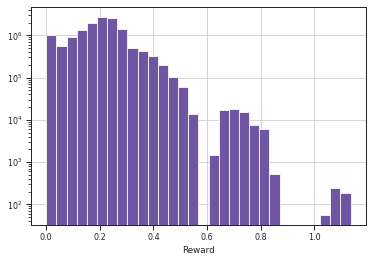

In [98]:
df_merged.reward.hist(bins=30, color='#7055a3')
plt.yscale("log")jk
plt.xlabel("Reward")
# plt.title(f"All decorations")

In [168]:
len(df_merged)

14277451

## Visualize the decoration space

In [320]:
from upsetplot import generate_counts
from upsetplot import UpSet
from upsetplot import plot as plot_upset
example = generate_counts()
example

cat0   cat1   cat2 
False  False  False      56
              True      283
       True   False    1279
              True     5882
True   False  False      24
              True       90
       True   False     429
              True     1957
Name: value, dtype: int64

In [172]:
rewarder = StructureRewardBattInterface(None)
cutoffs = rewarder.reward_cutoffs
cutoffs

{'decomp_energy': -0.1,
 'cond_ion_frac': 0.3,
 'reduction': -2,
 'oxidation': -4,
 'stability_window': 2}

In [173]:
df_merged.head(2)

,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,Li1Ti2Ge1Cl1N4_icsd_419182_4,Li1Ti2Ge1Cl1N4,0.015,0.299,7.325,0.111,NaN,NaN,NaN
1,Li1La1Sb1I3O3_icsd_171662_12,Li1La1Sb1I3O3,0.036,-0.391,4.621,0.111,NaN,NaN,NaN


In [379]:
col = 'decomp_energy'
df_cutoffs = df_merged[['id', 'comp']]
for col in ['decomp_energy', 'oxidation']:
    df_cutoffs[col] = df_merged[col].progress_apply(lambda x: x <= cutoffs[col])
for col in ['cond_ion_frac', 'reduction', 'stability_window']:
    df_cutoffs[col] = df_merged[col].progress_apply(lambda x: x >= cutoffs[col])
    
df_cutoffs

  0%|          | 0/14277451 [00:00<?, ?it/s]

/tmp/ipykernel_28937/2806521132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoffs[col] = df_merged[col].progress_apply(lambda x: x <= cutoffs[col])


  0%|          | 0/14277451 [00:00<?, ?it/s]

/tmp/ipykernel_28937/2806521132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoffs[col] = df_merged[col].progress_apply(lambda x: x <= cutoffs[col])


  0%|          | 0/14277451 [00:00<?, ?it/s]

/tmp/ipykernel_28937/2806521132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoffs[col] = df_merged[col].progress_apply(lambda x: x >= cutoffs[col])


  0%|          | 0/14277451 [00:00<?, ?it/s]

/tmp/ipykernel_28937/2806521132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoffs[col] = df_merged[col].progress_apply(lambda x: x >= cutoffs[col])


  0%|          | 0/14277451 [00:00<?, ?it/s]

/tmp/ipykernel_28937/2806521132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoffs[col] = df_merged[col].progress_apply(lambda x: x >= cutoffs[col])


,id,comp,decomp_energy,oxidation,cond_ion_frac,reduction,stability_window
0,Li1Ti2Ge1Cl1N4_icsd_419182_4,Li1Ti2Ge1Cl1N4,False,False,False,False,False
1,Li1La1Sb1I3O3_icsd_171662_12,Li1La1Sb1I3O3,False,False,False,False,False
2,K1Hg1Al1F4O1_icsd_051463_2,K1Hg1Al1F4O1,False,False,False,False,False
3,Li3Al1F2S2_icsd_250396_2,Li3Al1F2S2,False,False,True,False,False
4,Li2Si1Sb1Br1S5_icsd_010176_5,Li2Si1Sb1Br1S5,False,False,False,False,False
...,...,...,...,...,...,...,...
4108670,Li1Hf4Al1S4P4_icsd_280039_2,Li1Hf4Al1S4P4,False,False,False,False,False
3989794,Li1La1Hf4S4P4_icsd_171416_4,Li1La1Hf4S4P4,False,False,False,False,False
834678,K1Hf4B1S4N4_icsd_171416_4,K1Hf4B1S4N4,False,False,False,False,False
2922469,K1La1Sb4N4P4_icsd_171416_4,K1La1Sb4N4P4,False,False,False,False,False


In [343]:
# add the conducting ion
# for cond_ion in ['Li', 'K', 'Na']:
    # df_cutoffs[cond_ion] = df_cutoffs.comp.progress_apply(lambda x: cond_ion in x)
def get_cond_ion(comp):
    for cond_ion in ['Li', 'K', 'Na']:
        if cond_ion in comp:
            return cond_ion
        
df_cutoffs['cond_ion'] = df_cutoffs.comp.progress_apply(get_cond_ion)
df_cutoffs.head(2)

  0%|          | 0/14277451 [00:00<?, ?it/s]

/tmp/ipykernel_28937/2483156594.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutoffs['cond_ion'] = df_cutoffs.comp.progress_apply(get_cond_ion)


,id,comp,decomp_energy,oxidation,cond_ion_frac,reduction,stability_window,cond_ion
0,Li1Ti2Ge1Cl1N4_icsd_419182_4,Li1Ti2Ge1Cl1N4,False,False,False,False,False,Li
1,Li1La1Sb1I3O3_icsd_171662_12,Li1La1Sb1I3O3,False,False,False,False,False,Li


In [344]:
df_cutoffs = df_cutoffs.drop(columns=['id', 'comp'])

In [378]:
df_cutoffs.head(2)

,decomp_energy,oxidation,cond_ion_frac,reduction,stability_window,cond_ion
0,False,False,False,False,False,Li
1,False,False,False,False,False,Li


In [235]:
# df_cutoffs = df_cutoffs.drop(columns=['id', 'comp'])
# df_cutoffs = df_cutoffs[['stability_window', 'reduction', 'oxidation', 'cond_ion_frac', 'decomp_energy']]
# # only count oxidation, reduction, and stability window if decomp_energy is True
# df_cutoffs.loc[(df_cutoffs['oxidation']) & ~(df_cutoffs['decomp_energy'])] = False
# df_cutoffs.loc[(df_cutoffs['reduction']) & ~(df_cutoffs['decomp_energy'])] = False
# df_cutoffs.loc[(df_cutoffs['stability_window']) & ~(df_cutoffs['decomp_energy'])] = False

df_cutoffs.columns = ['Stability Window >   2', 'Reduction >   -2', 'Oxidation <   -4', 'Conducting Ion % >  30', 'Decomp. Energy < -0.1']
df_cutoffs.head(2)

,Stability Window > 2,Reduction > -2,Oxidation < -4,Conducting Ion % > 30,Decomp. Energy < -0.1
0,False,False,False,False,False
1,False,False,False,False,False


In [236]:
counts = df_cutoffs.value_counts()
counts

Stability Window >   2  Reduction >   -2  Oxidation <   -4  Conducting Ion % >  30  Decomp. Energy < -0.1
False                   False             False             False                   False                    12121459
                                                            True                    False                     2089355
True                    False             True              False                   True                        28174
False                   False             True              False                   True                        24167
True                    True              True              False                   True                        11529
                                                            True                    True                          494
                                          False             False                   True                          469
False                   False             False             False   

/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pass_cutoffs_upset_plot.svg


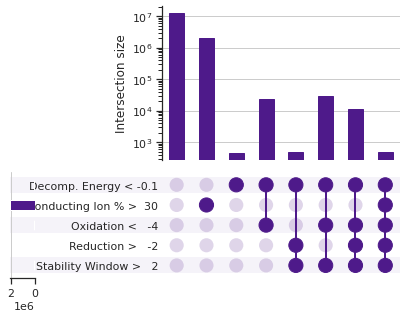

In [278]:
fig = plt.figure(figsize=(7, 5))
plot_upset(counts, 
           fig=fig, element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=7,
           facecolor="#4e1a8a",
           # show_counts=True,
           # show_percentages=True,
           min_subset_size=400, 
           # max_subset_size=10000,
           sort_categories_by=None)
plt.yscale('log')
# plt.xscale('log')
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pass_cutoffs_upset_plot.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg', '.png'), bbox_inches='tight')

In [285]:
counts.iloc[2:]

Stability Window >   2  Reduction >   -2  Oxidation <   -4  Conducting Ion % >  30  Decomp. Energy < -0.1
True                    False             True              False                   True                     28174
False                   False             True              False                   True                     24167
True                    True              True              False                   True                     11529
                                                            True                    True                       494
                                          False             False                   True                       469
False                   False             False             False                   True                       445
                        True              False             True                    True                       387
True                    False             True              True                    True 

/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pass_cutoffs_upset_plot.svg


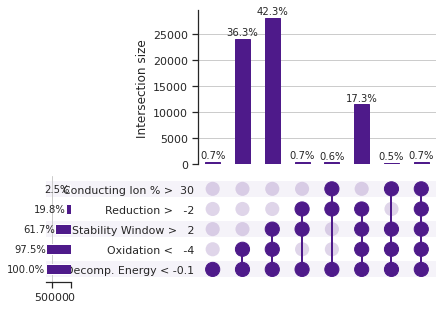

In [317]:
fig = plt.figure(figsize=(7, 5))
plot_upset(counts.iloc[2:],
           fig=fig, element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=7,
           facecolor="#4e1a8a",
           # show_counts=True,
           show_percentages="%0.1f%%",
           min_subset_size=300, 
           # max_subset_size=100000,
           # sort_categories_by=None
          )
# plt.yscale('log')
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pass_cutoffs_upset_plot.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg', '.png'), bbox_inches='tight')

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

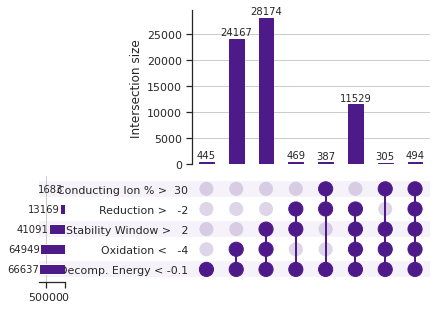

In [319]:
fig = plt.figure(figsize=(7, 5))
plot_upset(counts.iloc[2:],
           fig=fig, element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=7,
           facecolor="#4e1a8a",
           show_counts=True,
           # show_percentages="%0.1f%%",
           min_subset_size=300, 
           # max_subset_size=100000,
           # sort_categories_by=None
          )

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

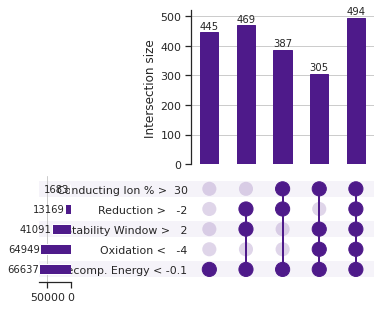

In [335]:
fig = plt.figure(figsize=(6, 5))
upset = UpSet(counts.iloc[2:],
           # fig=fig, 
              element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=7,
           facecolor="#4e1a8a",
           show_counts=True,
           # show_percentages="%0.1f%%",
           min_subset_size=300, 
           max_subset_size=10000,
           # sort_categories_by=None
          )
# upset = UpSet(df,
#               intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="Sex", colors=cm.Pastel1,
                       title="Count by gender", elements=10)
upset.plot(fig=fig)

In [346]:
df2 = df_cutoffs[df_cutoffs['decomp_energy']]
df2 = df2.set_index(['decomp_energy', 'oxidation', 'cond_ion_frac', 'reduction', 'stability_window'])
df2.head(2)

cond_ion
decomp_energy oxidation cond_ion_frac reduction stability_window         
True          True      False         False     True                    K
                                                True                    K

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'extra0': <AxesSubplot:ylabel='Intersection Size'>}

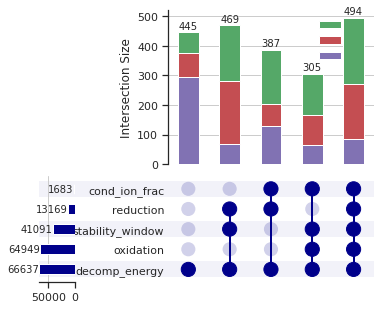

In [375]:
fig = plt.figure(figsize=(6, 5))
upset = UpSet(df2,
           # fig=fig, 
              element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=0,
           # intersection_plot_elements=7,
           # facecolor="#4e1a8a",  # dark purple
           facecolor="darkblue",
           show_counts=True,
           # show_percentages="%0.1f%%",
           min_subset_size=300, 
           max_subset_size=10000,
           # sort_categories_by=None
          )
# upset = UpSet(df,
#               intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="cond_ion", colors=sns.color_palette(n_colors=5),
                       elements=7,
                       title="Intersection Size") #elements=10)
upset.plot(fig=fig)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'extra0': <AxesSubplot:ylabel='Intersection Size'>}

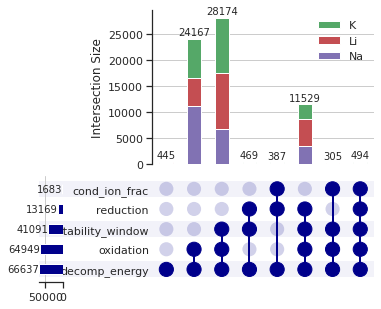

In [377]:
fig = plt.figure(figsize=(6, 5))
upset = UpSet(df2,
           # fig=fig, 
              element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=0,
           # intersection_plot_elements=7,
           # facecolor="#4e1a8a",  # dark purple
           facecolor="darkblue",
           show_counts=True,
           # show_percentages="%0.1f%%",
           min_subset_size=300, 
           # max_subset_size=10000,
           # sort_categories_by=None
          )
# upset = UpSet(df,
#               intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="cond_ion", colors=sns.color_palette(n_colors=5),
                       elements=7,
                       title="Intersection Size") #elements=10)
upset.plot(fig=fig)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

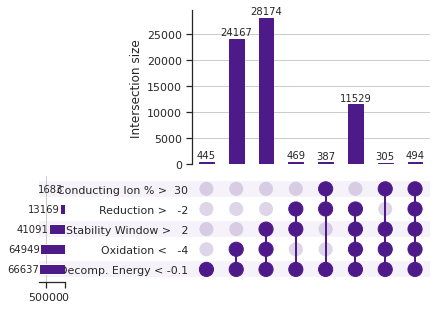

In [319]:
fig = plt.figure(figsize=(7, 5))
plot_upset(counts.iloc[2:],
           fig=fig, element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=7,
           facecolor="#4e1a8a",
           show_counts=True,
           # show_percentages="%0.1f%%",
           min_subset_size=300, 
           # max_subset_size=100000,
           # sort_categories_by=None
          )

In [297]:
for col in ['cond_ion_frac', 'oxidation', 'reduction', 'stability_window']:
    print(col, len(df_cutoffs[(df_cutoffs[col]) & (df_cutoffs.decomp_energy)]))

cond_ion_frac 1683
oxidation 64949
reduction 13169
stability_window 41091


In [293]:
counts.iloc[2:].sum()

66637

### Examine the element types among the high-reward structures

In [ ]:
from pymatgen.core import Composition

In [425]:
col = 'decomp_energy'
df_ele_types = df_merged[df_merged.decomp_energy <= -.1][['id', 'comp']]
ele_groups = {
    # F, Cl, Br, I
    'Halides': [9, 17, 35, 53],
    'Oxides': [8],
    # S, Se, Te
    'Chalcogenides': [16, 34, 52, 84],
    # C, Si, Ge, Sn, Pb
    'Tetrels': [6, 14, 32, 50, 82],
    # N, P, As, Sb, Bi
    'Pnictogens': [7, 15, 33, 51, 83],
    # La?
    'Sc, Y': [21, 39],
    'Ti, Zr, Hf': [22, 40, 72],
    'Zn, Cd, Hg': [30, 48, 80],
    'B, Al': [5, 13],
    # W (tungsten)
    # 'W': [74],
}

def has_ele_type(comp, group=None):
    comp = Composition(comp)
    return any(e.Z in ele_groups[group] for e in comp.elements)


for group in ele_groups:
    df_ele_types[group] = df_ele_types.comp.apply(has_ele_type, group=group)
    
df_ele_types.head(2)

,id,comp,Halides,Oxides,Chalcogenides,Tetrels,Pnictogens,"Sc, Y","Ti, Zr, Hf","Zn, Cd, Hg","B, Al"
394,K1Hf1Cl1Br4_icsd_097456_6,K1Hf1Cl1Br4,True,False,False,False,False,False,True,False,False
418,K2Sc1Br4I1_icsd_092429_1,K2Sc1Br4I1,True,False,False,False,False,True,False,False,False


In [426]:
counts = df_ele_types.drop(columns=['id', 'comp']).value_counts()
counts

Halides  Oxides  Chalcogenides  Tetrels  Pnictogens  Sc, Y  Ti, Zr, Hf  Zn, Cd, Hg  B, Al
True     False   False          False    False       True   False       False       False    33191
                                                                        True        False     8705
                                                     False  True        False       False     7025
                                                            False       False       True      6577
                                                     True   False       False       True      2678
                                                                                             ...  
False    False   True           True     False       False  True        False       False        1
         True    False          False    True        False  True        False       False        1
True     True    False          False    False       False  True        True        False        1
False    False   Fa

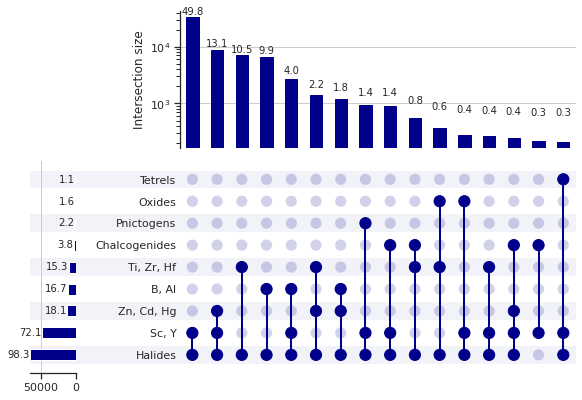

In [427]:
fig = plt.figure(figsize=(7, 5))
upset = UpSet(counts,
           # fig=fig, 
              # element_size=None,
               # totals_plot_elements=1,
               # intersection_plot_elements=7,
               # facecolor="#4e1a8a",  # dark purple
               facecolor="darkblue",
               # show_counts=True,
               show_percentages="%0.1f",
               min_subset_size=200, 
              sort_by="cardinality",
              
           # max_subset_size=10000,
           # sort_categories_by=None
          )
# upset.add_stacked_bars(by="cond_ion", colors=sns.color_palette(n_colors=5),
#                        elements=7,
#                        title="Intersection size")
upset.plot(fig=fig)
plt.yscale('log')

In [420]:
from importlib import reload
import upsetplot
reload(upsetplot)
from upsetplot import plotting
reload(plotting)

<module 'upsetplot.plotting' from '/home/jlaw/.conda-envs/crystals_nfp0_3/lib/python3.8/site-packages/upsetplot/plotting.py'>

/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/ele_types_upset_plot.svg


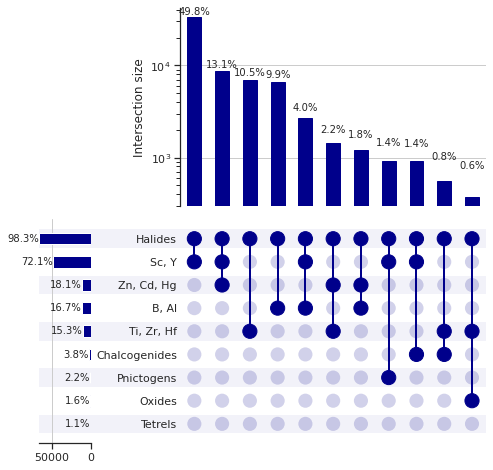

In [436]:
fig = plt.figure(figsize=(8, 8))
upset = upsetplot.UpSet(counts,
           # fig=fig, 
              element_size=None,
               # totals_plot_elements=1,
               intersection_plot_elements=8,
               # facecolor="#4e1a8a",  # dark purple
               facecolor="darkblue",
               # show_counts=True,
               show_percentages="%0.1f%%",
               min_subset_size=300, 
              sort_by="cardinality",
              sort_categories_by="cardinality_r",
              
           # max_subset_size=10000,
           # sort_categories_by=None
          )
# upset.add_stacked_bars(by="cond_ion", colors=sns.color_palette(n_colors=5),
#                        elements=7,
#                        title="Intersection size")
upset.plot(fig=fig)
plt.yscale('log')
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/ele_types_upset_plot.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg', '.png'), bbox_inches='tight')

In [438]:
# add the conducting ion
# for cond_ion in ['Li', 'K', 'Na']:
    # df_cutoffs[cond_ion] = df_cutoffs.comp.progress_apply(lambda x: cond_ion in x)
def get_cond_ion(comp):
    for cond_ion in ['Li', 'K', 'Na']:
        if cond_ion in comp:
            return cond_ion
        
df_ele_types['cond_ion'] = df_ele_types.comp.apply(get_cond_ion)
df_ele_types.head(2)

,id,comp,Halides,Oxides,Chalcogenides,Tetrels,Pnictogens,"Sc, Y","Ti, Zr, Hf","Zn, Cd, Hg","B, Al",cond_ion
394,K1Hf1Cl1Br4_icsd_097456_6,K1Hf1Cl1Br4,True,False,False,False,False,False,True,False,False,K
418,K2Sc1Br4I1_icsd_092429_1,K2Sc1Br4I1,True,False,False,False,False,True,False,False,False,K


In [441]:
df_ele_types = df_ele_types.drop(columns=['id', 'comp']).set_index(['Halides', 'Oxides', 'Chalcogenides', 'Tetrels', 'Pnictogens', 'Sc, Y', 'Ti, Zr, Hf', 'Zn, Cd, Hg', 'B, Al'])

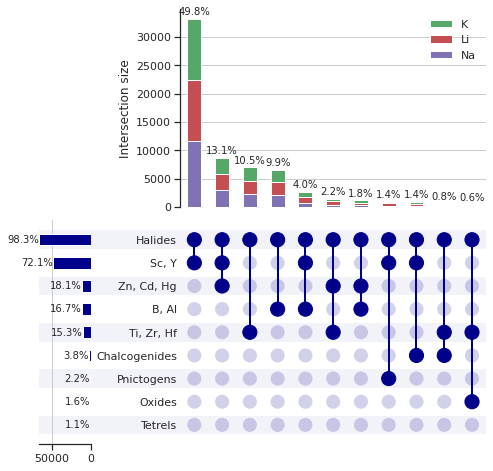

In [444]:
fig = plt.figure(figsize=(8, 8))
upset = upsetplot.UpSet(df_ele_types,
           # fig=fig, 
              element_size=None,
               # totals_plot_elements=1,
               intersection_plot_elements=0,
               # facecolor="#4e1a8a",  # dark purple
               facecolor="darkblue",
               # show_counts=True,
               show_percentages="%0.1f%%",
               min_subset_size=300, 
              sort_by="cardinality",
              sort_categories_by="cardinality_r",
              
           # max_subset_size=10000,
           # sort_categories_by=None
          )
upset.add_stacked_bars(by="cond_ion", colors=sns.color_palette(n_colors=5),
                       elements=8,
                       title="Intersection size")
upset.plot(fig=fig)
# plt.yscale('log')
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/ele_types_upset_plot.svg"
# print(out_file)
# plt.savefig(out_file, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg', '.png'), bbox_inches='tight')

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'extra0': <AxesSubplot:ylabel='Intersection size'>}

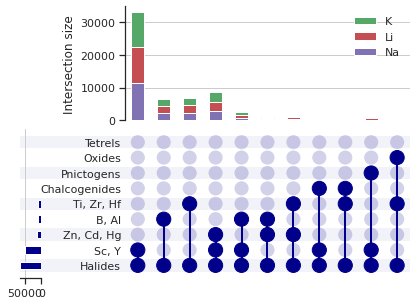

In [394]:
fig = plt.figure(figsize=(7, 5))
upset = UpSet(df_ele_types,
           # fig=fig, 
              element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=0,
           # facecolor="#4e1a8a",  # dark purple
           facecolor="darkblue",
           # show_counts=True,
           # show_percentages="%0.1f%%",
           min_subset_size=300, 
           # max_subset_size=10000,
           # sort_categories_by=None
          )
upset.add_stacked_bars(by="cond_ion", colors=sns.color_palette(n_colors=5),
                       elements=7,
                       title="Intersection size")
upset.plot(fig=fig)
# plt.yscale('log')

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'extra0': <AxesSubplot:ylabel='Intersection size'>}

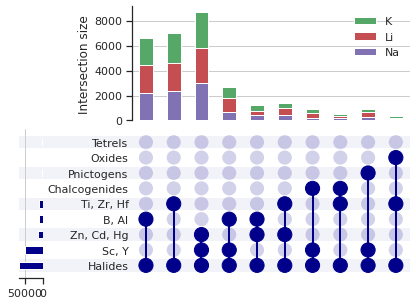

In [395]:
fig = plt.figure(figsize=(7, 5))
upset = UpSet(df_ele_types,
           # fig=fig, 
              element_size=None,
           totals_plot_elements=1,
           intersection_plot_elements=0,
           # facecolor="#4e1a8a",  # dark purple
           facecolor="darkblue",
           # show_counts=True,
           # show_percentages="%0.1f%%",
           min_subset_size=300, 
           max_subset_size=10000,
           # sort_categories_by=None
          )
upset.add_stacked_bars(by="cond_ion", colors=sns.color_palette(n_colors=5),
                       elements=7,
                       title="Intersection size")
upset.plot(fig=fig)
# plt.yscale('log')

### Extract the high-reward structures

In [48]:
df_top = df_merged[df_merged.reward > 0.6]
print(len(df_top), len(df_merged), len(df_top) / len(df_merged))

66571 14277451 0.004662667026488132


,id
comp,
Li4Y1Br7,Li4Y1Br7_icsd_001322_1


In [132]:
# rather than use the reward directly,
# keep the structure with the lowest predicted total energy
# df_comp = df_top.sort_values('reward', ascending=False).groupby('comp').agg({'id': 'first'})
df_comp = df_top.sort_values('predicted_energy').groupby('comp').agg({'id': 'first'})

In [127]:
num_comps = df_merged.comp.nunique()
print(len(df_comp), num_comps, len(df_comp) / num_comps)

2003 220824 0.009070572039271094


In [133]:
df_best = df_top[df_top.id.isin(df_comp.id)]
len(df_best)

2003

In [129]:
df_best.head(2)

,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
13938,Na2Hf1F1Br5_icsd_043729_1,Na2Hf1F1Br5,0.744,-3.937,-0.482,0.222,-2.108,-5.0,2.892
19013,Li1Sc2Hg1Br7S1_icsd_166998_4,Li1Sc2Hg1Br7S1,0.702,-3.252,-0.339,0.083,-2.531,-5.0,2.469


In [130]:
df_best = df_best.sort_values('reward', ascending=False)
df_best.head(2)

,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
769706,Li3Y1Br6_icsd_053533_1,Li3Y1Br6,1.135173,-3.798492,-0.8512,0.3000,-0.6734,-5.0,4.3266
7954,Li4Y1Br7_icsd_001322_1,Li4Y1Br7,1.132112,-3.735198,-0.7266,0.3333,-0.6045,-5.0,4.3955


In [135]:
out_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05"
out_file = f"{out_dir}/best_decor_rewards.csv.gz"
df_best.to_csv(out_file, index=False)

## Now write the best structures to file

In [136]:
import gzip, json
from pymatgen.core import Structure
def read_structures_file(structures_file):
    print(f"reading {structures_file}")
    with gzip.open(structures_file, 'r') as f:
        structures_dict = json.loads(f.read().decode())
    structures = {}
    for key, structure_dict in structures_dict.items():
        structures[key] = Structure.from_dict(structure_dict)
    print(f"\t{len(structures)} structures read")
    return structures

In [76]:
# load the icsd prototype structures
from pymatgen.transformations.standard_transformations import OxidationStateRemovalTransformation
oxidation_remover = OxidationStateRemovalTransformation()
icsd_prototypes_file = "../../rlmolecule/crystal/inputs/icsd_train_and_proto_max_comp_atoms15/KLiNa_add_clust0_01_min10prototypes.json.gz"
proto_structures = read_structures_file(icsd_prototypes_file)
proto_structures = {s_id: oxidation_remover.apply_transformation(s)
                    for s_id, s in proto_structures.items()}

reading ../../rlmolecule/crystal/inputs/icsd_train_and_proto_max_comp_atoms15/KLiNa_add_clust0_01_min10prototypes.json.gz
	14494 structures read


In [60]:
def decorate_structure(decorated_str, prototypes=None, vol_pred_site_bias=None):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = prototypes[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    # print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        # also predict the volume
        if vol_pred_site_bias is not None:
            decorated_structure = scale_by_pred_vol(decorated_structure, 
                                                    vol_pred_site_bias,
                                                    dls_vol_predictor,
                                                   )
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}
    
    return decorated_structure

In [107]:
proto_to_crystal_sys = {proto_id.split('|')[-1]: proto_id.split('|')[1] 
                        for proto_id in proto_structures.keys()}

In [67]:
import re
def split_comp_to_eles_and_type(comp: str):
    """
    Extract the elements and composition type from a given composition
    e.g., _1_1_4 from Li1Sc1F4
    """
    # this splits by the digits
    # e.g., for "Li1Sc1F4": ['Li', '1', 'Sc', '1', 'F', '4', '']
    comp = comp.replace(' ','')
    split = np.asarray(re.split('(\d+)', comp))
    elements = tuple(sorted(split[range(0, len(split) - 1, 2)]))
    stoich = split[range(1, len(split), 2)]
    # sort the stoichiometry to get the correct order of the comp type
    comp_type = '_' + '_'.join(map(str, sorted(map(int, stoich))))
    return elements, comp_type

In [137]:
df_best['comp_type'] = df_best.comp.apply(lambda x: split_comp_to_eles_and_type(x)[1])

In [138]:
df_best.head(2)

,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,comp_type
769706,Li3Y1Br6_icsd_053533_1,Li3Y1Br6,1.135173,-3.798492,-0.8512,0.3000,-0.6734,-5.0,4.3266,_1_3_6
7954,Li4Y1Br7_icsd_001322_1,Li4Y1Br7,1.132112,-3.735198,-0.7266,0.3333,-0.6045,-5.0,4.3955,_1_4_7


In [85]:
def get_decor_id(strc_id):
    strc_id = strc_id.split("_")
    comp = strc_id[0]
    comp_type = split_comp_to_eles_and_type(comp)[1]
    proto_id = "_".join(strc_id[1:-1])
    # proto_id = "icsd_" + strc_id.split("_")[2]
    crystal_sys = proto_to_crystal_sys[proto_id]
    decor = strc_id[-1]
    decor_id = "|".join([comp, comp_type, crystal_sys, proto_id, decor])
    return decor_id

In [139]:
df_best['decor_id'] = df_best.id.apply(get_decor_id)
df_best.head(2)

,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,comp_type,decor_id
769706,Li3Y1Br6_icsd_053533_1,Li3Y1Br6,1.135173,-3.798492,-0.8512,0.3000,-0.6734,-5.0,4.3266,_1_3_6,Li3Y1Br6|_1_3_6|trigonal|icsd_053533|1
7954,Li4Y1Br7_icsd_001322_1,Li4Y1Br7,1.132112,-3.735198,-0.7266,0.3333,-0.6045,-5.0,4.3955,_1_4_7,Li4Y1Br7|_1_4_7|cubic|icsd_001322|1


In [140]:
df_best['structure'] = df_best.decor_id.progress_apply(decorate_structure,
                                                     prototypes=proto_structures,
                                                     # vol_pred_site_bias=site_bias,
                                                     )
# df_all['volume'] = df_all.structure.apply(lambda x: x.volume)
# df_all['dls_volume'] = df_all.structure.apply(lambda x: x.volume)
df_best.to_pickle(f"{out_dir}/best_decorations.p")

  0%|          | 0/2003 [00:00<?, ?it/s]

In [89]:
def write_structure(row, out_dir):
    out_file = f"{out_dir}/best_decorations/POSCAR_{row.id}"
    row.structure.to(filename=out_file)

In [141]:
os.makedirs(f"{out_dir}/best_decorations", exist_ok=True)
df_best.progress_apply(write_structure, out_dir=out_dir, axis=1)

  0%|          | 0/2003 [00:00<?, ?it/s]

769706     None
7954       None
913341     None
902942     None
382639     None
           ... 
3931257    None
472112     None
4616722    None
4778209    None
4371793    None
Length: 2003, dtype: object

<AxesSubplot:xlabel='decomp_energy', ylabel='stability_window'>

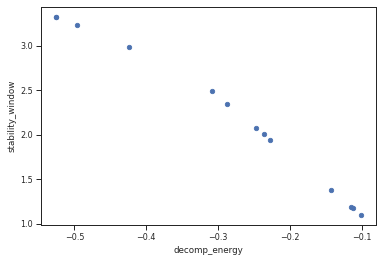

In [144]:
df_top[df_top.comp == "K3Sc1Br4I2"].plot.scatter(x="decomp_energy", y='stability_window')

In [161]:
df_top.sort_values("predicted_energy", inplace=True)

/tmp/ipykernel_28937/1586870522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top.sort_values("predicted_energy", inplace=True)


In [ ]:
df_top[df_top.comp == "K1Hg1F3"]

In [163]:
df_top.to_csv(f"{out_dir}/decor_rewards_gt0_6.csv.gz", index=False)